In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d as scipy_interp1d
import matplotlib.pyplot as plt


In [14]:
# Precompute Gauss-Hermite numbers
gausshermite_xi_deg25, gausshermite_wi_deg25 = np.polynomial.hermite.hermgauss(25)
print(gausshermite_xi_deg25)
# Cosmology function class
integrate_epsrel=1e-5
n_subintrv = 100

class CosmoFuncs():
    """
    docstring for CosmoFn"""
    def __init__(self, OMEGA_M, OMEGA_L, h):
        self.OMEGA_M  = OMEGA_M
        self.OMEGA_L  = OMEGA_L
        self.h        = h
        self.OMEGA_K  = 1. - (OMEGA_M + OMEGA_L)
        self.HUBBLE_0 = 100. # h km/s/Mpc
        
        self.LinearGrowthNorm = 0


    def Hubble(self, z):
        return self.HUBBLE_0 * np.sqrt(self.OMEGA_M * (1. + z)**3 \
                                     + self.OMEGA_K * (1. + z)**2 \
                                     + self.OMEGA_L)
    def DzHubble(self, z):
        r1 = 1.5 * self.OMEGA_M * (1. + z)**2 + self.OMEGA_K * (1. + z)
        return r1 * self.HUBBLE_0**2 / self.Hubble(z)

    def ComovingAngularDiameter(self, z):
        def recp_hbl(zp):
            return 1. / self.Hubble(zp)

        return quad(recp_hbl, 0, z, limit = n_subintrv)[0]

    def LinearGrowthFn(self, z):
        def integrandLinearGrowth(zp):
            return (1. + zp) / self.Hubble(zp)**3

        if self.LinearGrowthNorm == 0:
            self.LinearGrowthNorm = 1. / quad(integrandLinearGrowth, 0, np.inf, limit = n_subintrv)[0] / self.HUBBLE_0

        return self.LinearGrowthNorm * self.Hubble(z) * quad(integrandLinearGrowth, z, np.inf, limit = n_subintrv)[0]

    def DzLinearGrowthFn(self, z):
        hz  = self.Hubble(z)
        r1  = self.LinearGrowthFn(z) * self.DzHubble(z) / hz
        r1 -= self.LinearGrowthNorm * (1. + z) / hz**2

        return r1

    def GrowthFactorRSD(self, z):
        return - (1.+z) * self.DzLinearGrowthFn(z) / self.LinearGrowthFn(z)

[-6.16427243 -5.41363636 -4.78532037 -4.21860944 -3.69028288 -3.18829492
 -2.70532024 -2.23642013 -1.77800112 -1.3272807  -0.88198276 -0.4401473
  0.          0.4401473   0.88198276  1.3272807   1.77800112  2.23642013
  2.70532024  3.18829492  3.69028288  4.21860944  4.78532037  5.41363636
  6.16427243]


In [18]:
cosmo = CosmoFuncs(OMEGA_M=0.3, OMEGA_L=0.7, h=0.7)
zarr = np.linspace(0, 100, 10000)
Dz = np.zeros_like(zarr)
for i in range(len(zarr)):
    Dz[i] = cosmo.LinearGrowthFn(zarr[i])

interp_dz = scipy_interp1d(zarr, Dz)

f0 = cosmo.GrowthFactorRSD(0)

In [19]:
Z0=3.0
z_ratio = lambda z: (1+z)/(1+Z0)

def getTau0(z, A0=1.48, A1=4.5):
    return np.power(z_ratio(z), A1) * np.exp(A0)

def getAlpha(z):
    return 1.65

def getSigmaEpsilon(z, A0=0.602, A1=0.276):
    return np.power(z_ratio(z), A1) * np.exp(A0)

def getSigmaCartesian(z):
    return 0.85

def getSigmaVelocity(z):
    return 0.75

def getX(z):
    sigma_G_2 = getSigmaEpsilon(z)**2 + getSigmaCartesian(z)**2
    return getTau0(z)*np.exp(-getAlpha(z) * interp_dz(z)**2 * sigma_G_2 / 2)

def getOpticalDepth(z, delta_C, delta_E):
    tempxz = getX(z)
    delta_G = getSigmaCartesian(z)*delta_C + getSigmaEpsilon(z)*delta_E
    tau = tempxz * np.exp(getAlpha(z) * interp_dz(z) * np.sqrt(2) * delta_G)
    
    return tau
    
# Assume z is 1d array
def calculateLyaCoLoReMeanFlux(z):
    ZZ, YY1, YY2 = np.meshgrid(z, gausshermite_xi_deg25, gausshermite_xi_deg25, indexing='ij')
    WW1, WW2 = np.meshgrid(gausshermite_wi_deg25, gausshermite_wi_deg25, indexing='ij')
    
    F = np.exp(-getOpticalDepth(ZZ, YY1, YY2))
    result = np.sum(WW1*WW2*F, axis=(1,2))
    
    return result / np.pi

def calculateLyaCoLoReMeanFlux_RSD(z):
    ZZ, YY1, YY2, YY3 = np.meshgrid(z, gausshermite_xi_deg25, \
        gausshermite_xi_deg25, gausshermite_xi_deg25, indexing='ij')
    WW1, WW2, WW3 = np.meshgrid(gausshermite_wi_deg25, gausshermite_wi_deg25, \
        gausshermite_wi_deg25, indexing='ij')
    
    zp = ZZ+YY3
    zp[zp<0] = 0
    
    F = np.exp(-getOpticalDepth(zp, YY1, YY2))
    result = np.sum(WW1*WW2*WW3*F, axis=(1,2,3))
    
    return result / np.pi**1.5

In [20]:
zarr=np.linspace(0, 5, 100)
f_z= calculateLyaCoLoReMeanFlux(zarr)
fs_z = calculateLyaCoLoReMeanFlux_RSD(zarr)

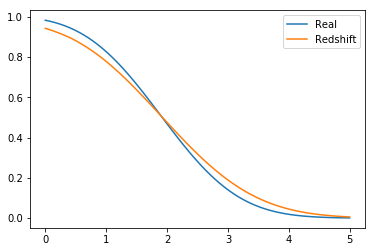

In [22]:
plt.plot(zarr, f_z, label="Real")
plt.plot(zarr, fs_z, label="Redshift")
plt.legend()